# Packages

In [4]:
# Importing necessary packages for CNN-based image classification on CIFAR-10 dataset using TensorFlow

# Data handling and processing
import numpy as np # type: ignore
import pandas as pd # type: ignore

# Deep learning framework
import tensorflow as tf # type: ignore
from sklearn.model_selection import train_test_split # type: ignore
from tensorflow.keras.applications import MobileNetV2 # type: ignore
from tensorflow.keras.models import Model, Sequential # type: ignore
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau # type: ignore
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, MaxPooling2D, Flatten, Add, GlobalAveragePooling2D, Dense, Input, Dropout, Activation # type: ignore
from tensorflow.keras.optimizers import Adam, SGD # type: ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore
from tensorflow.keras.datasets import cifar10 # type: ignore

# metrics
from sklearn.metrics import classification_report, confusion_matrix # type: ignore

# Visualization
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore

# Check TensorFlow version
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.17.0


In [5]:
pd.set_option('display.max_rows', 20)  # Display up to 500 rows
pd.set_option('display.max_columns', 150)  # Display up to 150 columns
pd.set_option('display.max_colwidth', None)  # Display full content of the cell

# 1. Initialization

## 1.1 Loading the data


In [6]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


## 1.2 Data summary for CIFAR-10 dataset

In [7]:
def data_summary(x_train, y_train, x_test, y_test):
    # Number of training and test samples
    print("Number of training samples:", x_train.shape[0])
    print("Number of test samples:", x_test.shape[0])

    # Image shape and channels
    print("Image shape:", x_train.shape[1:])
    print("Number of classes:", len(np.unique(y_train)))

data_summary(x_train, y_train, x_test, y_test)

Number of training samples: 50000
Number of test samples: 10000
Image shape: (32, 32, 3)
Number of classes: 10


# 2. Exploratory Data Analysis (EDA)

## 2.1 Sample images from the CIFAR-10 dataset

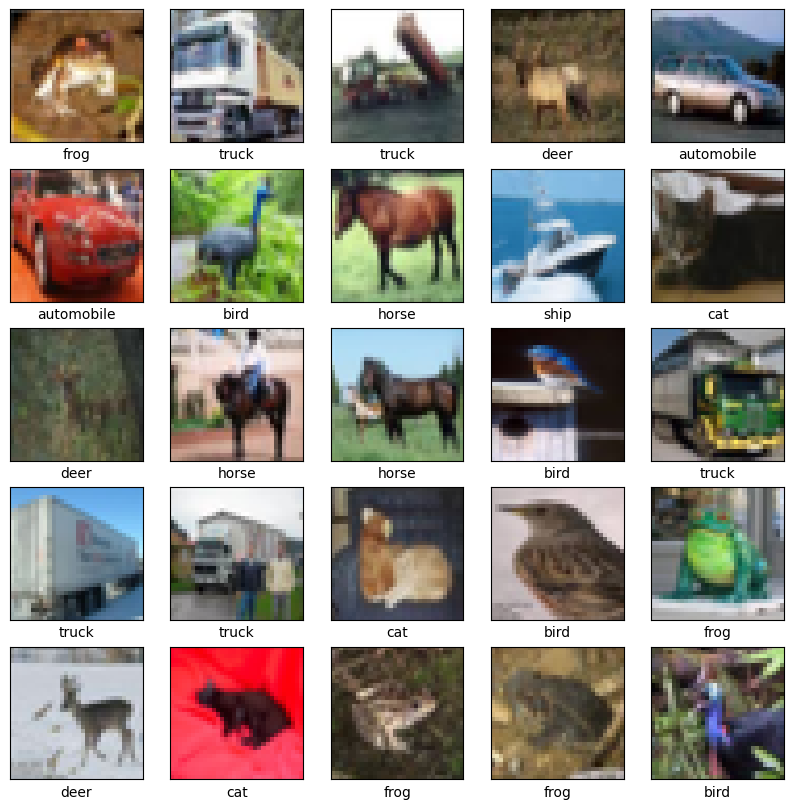

In [8]:
# Function to display a 5x5 grid of sample images from the CIFAR-10 dataset
def plot_25_sample_images(x_train, y_train, class_names):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(x_train[i])
        # CIFAR-10 labels are arrays, so we access the label with y_train[i][0]
        plt.xlabel(class_names[y_train[i][0]])
    plt.show()

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plot_25_sample_images(x_train, y_train, class_names)

## 2.2 Class distribution of the dataset

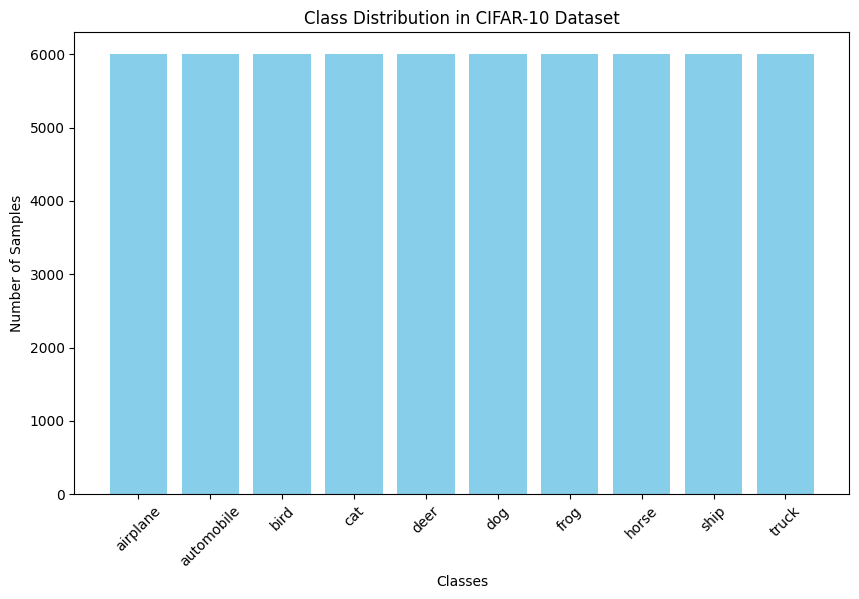

In [9]:
# Function to plot class distribution across both training and test datasets
def plot_class_distribution(y_data, class_names):
    unique, counts = np.unique(y_data, return_counts=True)
    plt.figure(figsize=(10, 6))
    plt.bar(class_names, counts, color='skyblue')
    plt.title(f"Class Distribution in CIFAR-10 Dataset")
    plt.xlabel("Classes")
    plt.ylabel("Number of Samples")
    plt.xticks(rotation=45)
    plt.show()

plot_class_distribution(np.concatenate([y_train, y_test]), class_names)

# 3. Data Processing

## 3.1 Normalize

In [10]:
# Normalize the data (scale pixel values to the range 0-1)
x_train, x_test = x_train / 255.0, x_test / 255.0

## 3.2 Spliting the data

In [11]:
# Splitting the original test set into validation and test sets
x_val, x_test, y_val, y_test = train_test_split(
    x_test, y_test, test_size=0.5, random_state=42
)

# Showing the dimensions of the datasets after splitting
print("Training data shape:", x_train.shape, y_train.shape)
print("Validation data shape:", x_val.shape, y_val.shape)
print("Test data shape:", x_test.shape, y_test.shape)

Training data shape: (50000, 32, 32, 3) (50000, 1)
Validation data shape: (5000, 32, 32, 3) (5000, 1)
Test data shape: (5000, 32, 32, 3) (5000, 1)


# 4. Deep Learning Models

## 4.1 ResNet - 18

### 4.1.1 Building model from scratch

In [12]:
def residual_block(x, filters, stride=1):
    # Shortcut path
    shortcut = x

    # First convolutional layer in the block
    x = Conv2D(filters, kernel_size=3, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Second convolutional layer in the block
    x = Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    # If stride is not 1, adjust shortcut connection to match dimensions
    if stride != 1:
        shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Add shortcut connection and apply ReLU
    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

In [13]:
def build_resnet18(input_shape=(32, 32, 3), num_classes=10):
    inputs = Input(shape=input_shape)

    # Initial Convolutional Layer
    x = Conv2D(64, kernel_size=3, strides=1, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Residual Blocks with increasing filters and decreasing spatial dimensions
    x = residual_block(x, 64, stride=1)
    x = residual_block(x, 64, stride=1)

    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 128, stride=1)

    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 256, stride=1)

    x = residual_block(x, 512, stride=2)
    x = residual_block(x, 512, stride=1)

    # Global Average Pooling and Dense Output Layer
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Define the model
    model = Model(inputs, outputs)
    return model

In [14]:
# Instantiate the ResNet-18 model with custom name
ruhin_resnet18 = build_resnet18(input_shape=(32, 32, 3), num_classes=10)

# Compile the model
ruhin_resnet18.compile(
    optimizer=Adam(learning_rate=0.001),  # Initial learning rate, can be adjusted
    loss='sparse_categorical_crossentropy',  # Use sparse because CIFAR-10 labels are integers
    metrics=['accuracy']
)

# Display the model summary to check the architecture
# ruhin_resnet18.summary()

### 4.1.1 Trainning the model

In [15]:
# Define callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
]

# Start training
history = ruhin_resnet18.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=50,  # Initial epochs, can be adjusted
    batch_size=64,
    callbacks=callbacks
)

Epoch 1/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 47s 30ms/step - accuracy: 0.4176 - loss: 1.6626 - val_accuracy: 0.3230 - val_loss: 2.6657 - learning_rate: 0.0010
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.6855 - loss: 0.8873 - val_accuracy: 0.6766 - val_loss: 0.9219 - learning_rate: 0.0010
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.7761 - loss: 0.6368 - val_accuracy: 0.7446 - val_loss: 0.7320 - learning_rate: 0.0010
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.8331 - loss: 0.4813 - val_accuracy: 0.7702 - val_loss: 0.7062 - learning_rate: 0.0010
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8710 - loss: 0.3721 - val_accuracy: 0.8056 - val_loss: 0.5712 - learning_rate: 0.0010
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9043 - loss: 0.2755 - val_accuracy: 0.7926 - val_loss: 0.6563 - learning_rate: 0.0010
Epoch 7/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9292 - loss: 

### 4.1.3 Accurary and Loss

In [61]:
resnet18_training_accuracy = history.history['accuracy'][-10]
resnet18_validation_accuracy = history.history['val_accuracy'][-10]

print(f"Accuracy of ResNet18: {resnet18_training_accuracy}")
print(f"Validation Accuracy of ResNet18: {resnet18_validation_accuracy}")

Accuracy of ResNet18: 0.9565399885177612
Validation Accuracy of ResNet18: 0.7897999882698059


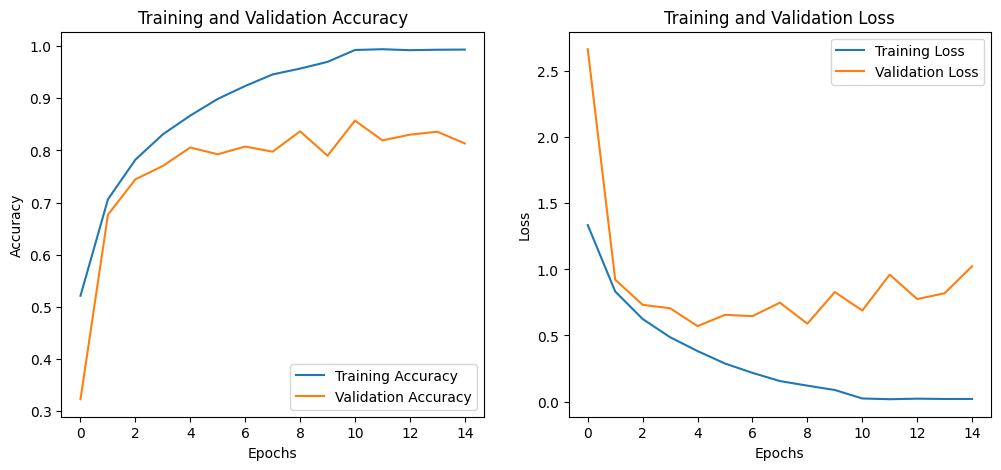

In [17]:
# Plot training & validation accuracy
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### 4.1.4 Performance metrics

157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step
Validation Classification Report:
               precision    recall  f1-score   support

    airplane       0.85      0.77      0.81       521
  automobile       0.96      0.85      0.90       514
        bird       0.69      0.72      0.70       475
         cat       0.72      0.57      0.64       500
        deer       0.71      0.86      0.78       494
         dog       0.81      0.72      0.76       522
        frog       0.71      0.92      0.81       489
       horse       0.84      0.85      0.84       472
        ship       0.93      0.86      0.90       511
       truck       0.86      0.93      0.90       502

    accuracy                           0.81      5000
   macro avg       0.81      0.81      0.80      5000
weighted avg       0.81      0.81      0.80      5000



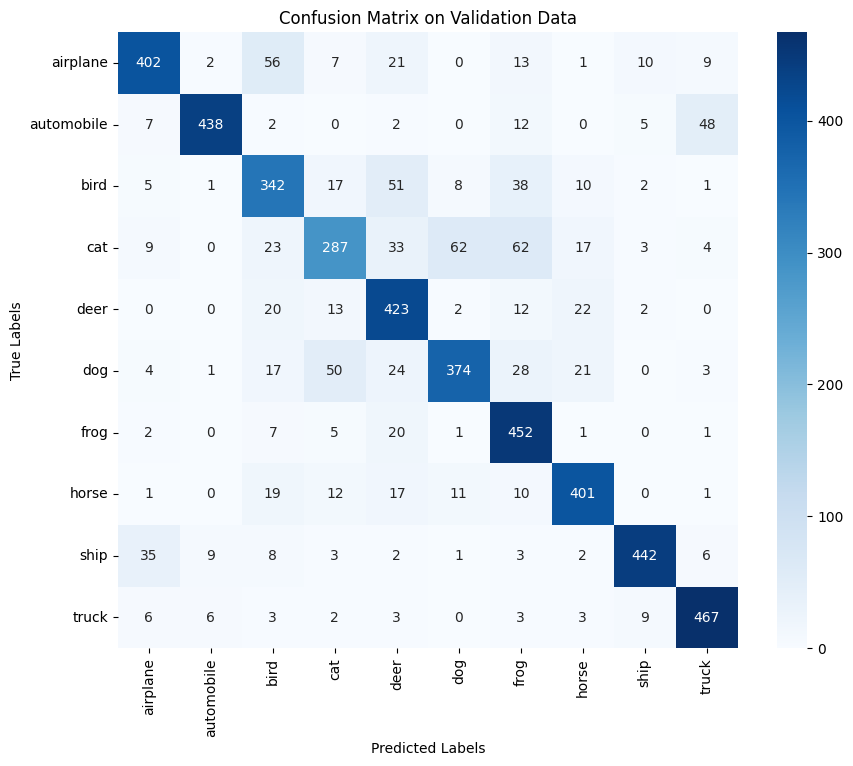

In [18]:
# Predict on the validation set
y_val_pred = ruhin_resnet18.predict(x_val)
y_val_pred_classes = y_val_pred.argmax(axis=1)

# Generate classification report for validation data
val_report = classification_report(y_val, y_val_pred_classes, target_names=class_names)
print("Validation Classification Report:\n", val_report)

# Generate confusion matrix for validation data
val_conf_matrix = confusion_matrix(y_val, y_val_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(val_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix on Validation Data")
plt.show()

## 4.2 AlexNet

### 4.2.1 Building the model from scratch

In [19]:
def build_alexnet(input_shape=(32, 32, 3), num_classes=10):
    model = Sequential()

    # Add an explicit Input layer
    model.add(Input(shape=input_shape))

    # First Convolutional Layer
    model.add(Conv2D(96, (3, 3), strides=1, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

    # Second Convolutional Layer
    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

    # Third Convolutional Layer
    model.add(Conv2D(384, (3, 3), padding='same'))
    model.add(Activation('relu'))

    # Fourth Convolutional Layer
    model.add(Conv2D(384, (3, 3), padding='same'))
    model.add(Activation('relu'))

    # Fifth Convolutional Layer
    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

    # Flatten and Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(4096))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(4096))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    # Output Layer
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    return model

# Instantiate the AlexNet model
AlexNet = build_alexnet(input_shape=(32, 32, 3), num_classes=10)

# Display the model summary
# AlexNet.summary()

In [20]:
# Compile the AlexNet model
AlexNet.compile(
    optimizer=Adam(learning_rate=0.001),  # Learning rate can be adjusted for experimentation
    loss='sparse_categorical_crossentropy',  # Use sparse because CIFAR-10 labels are integer encoded
    metrics=['accuracy']
)

# Display the model summary to confirm configuration
# AlexNet.summary()

### 4.2.2 Trainning the model

In [21]:
# Define callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
]

# Start training AlexNet
history_alexnet = AlexNet.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=50,  # Set a reasonable number of epochs; early stopping will halt training if needed
    batch_size=64,
    callbacks=callbacks
)

Epoch 1/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.2581 - loss: 1.9747 - val_accuracy: 0.5116 - val_loss: 1.3364 - learning_rate: 0.0010
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5315 - loss: 1.2900 - val_accuracy: 0.5882 - val_loss: 1.1449 - learning_rate: 0.0010
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6171 - loss: 1.0755 - val_accuracy: 0.6178 - val_loss: 1.0603 - learning_rate: 0.0010
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6668 - loss: 0.9463 - val_accuracy: 0.6710 - val_loss: 0.9316 - learning_rate: 0.0010
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7063 - loss: 0.8446 - val_accuracy: 0.6888 - val_loss: 0.8979 - learning_rate: 0.0010
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7360 - loss: 0.7606 - val_accuracy: 0.6852 - val_loss: 0.9251 - learning_rate: 0.0010
Epoch 7/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7560 - loss: 0.6920 

In [62]:
alexnet_training_accuracy = history_alexnet.history['accuracy'][-10]
alexnet_validation_accuracy = history_alexnet.history['val_accuracy'][-10]

print(f"Training Accuracy of AlexNet: {alexnet_training_accuracy}")
print(f"Validation Accuracy of AlexNet: {alexnet_validation_accuracy}")

Training Accuracy of AlexNet: 0.8061800003051758
Validation Accuracy of AlexNet: 0.7167999744415283


### 4.2.3 Accurary and Loss

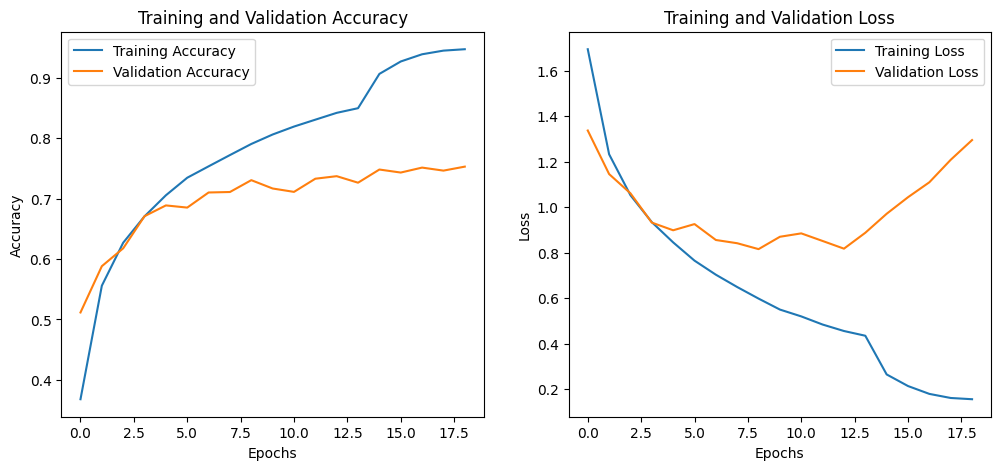

In [24]:
# Plot training & validation accuracy
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_alexnet.history['accuracy'], label='Training Accuracy')
plt.plot(history_alexnet.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_alexnet.history['loss'], label='Training Loss')
plt.plot(history_alexnet.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### 4.2.4 Performence metrics

157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
Validation Classification Report for AlexNet:
               precision    recall  f1-score   support

    airplane       0.69      0.82      0.75       521
  automobile       0.86      0.85      0.86       514
        bird       0.63      0.60      0.62       475
         cat       0.59      0.46      0.51       500
        deer       0.70      0.70      0.70       494
         dog       0.69      0.59      0.64       522
        frog       0.75      0.83      0.79       489
       horse       0.73      0.80      0.76       472
        ship       0.77      0.87      0.82       511
       truck       0.86      0.78      0.82       502

    accuracy                           0.73      5000
   macro avg       0.73      0.73      0.73      5000
weighted avg       0.73      0.73      0.73      5000



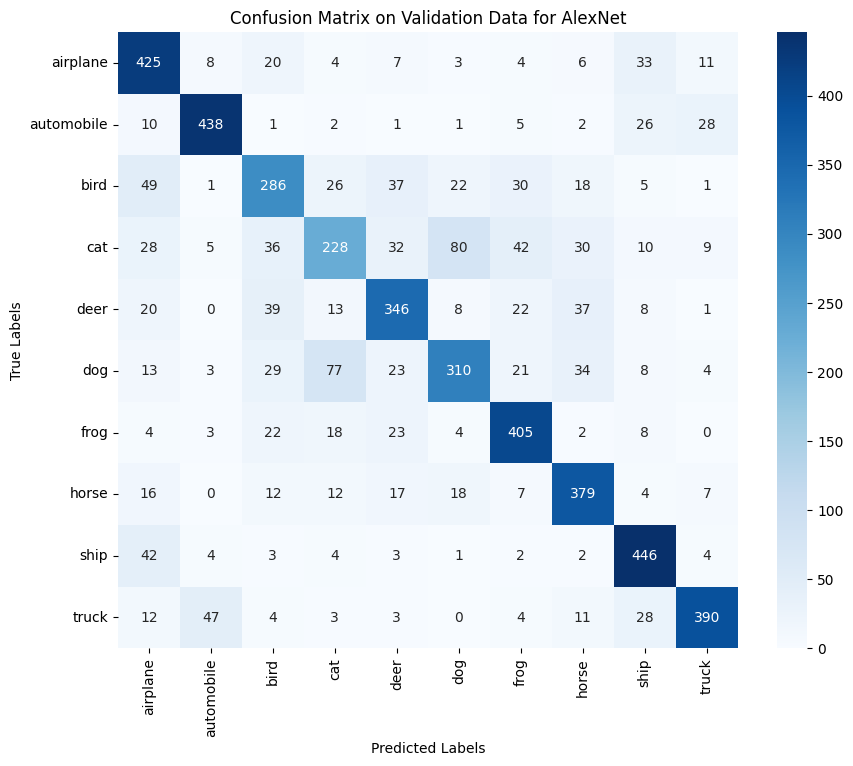

In [25]:
# Predict on the validation set
y_val_pred_alexnet = AlexNet.predict(x_val)
y_val_pred_classes_alexnet = y_val_pred_alexnet.argmax(axis=1)

# Generate classification report for validation data
val_report_alexnet = classification_report(y_val, y_val_pred_classes_alexnet, target_names=class_names, zero_division=0)
print("Validation Classification Report for AlexNet:\n", val_report_alexnet)

# Generate confusion matrix for validation data
val_conf_matrix_alexnet = confusion_matrix(y_val, y_val_pred_classes_alexnet)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(val_conf_matrix_alexnet, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix on Validation Data for AlexNet")
plt.show()

## 4.3 SimpleCNN

### 4.3.1 Building the model from scratch

In [26]:
# Define the SimpleCNN model architecture
def create_simple_cnn(input_shape=(32, 32, 3), num_classes=10):
    model = Sequential()

    # Add an explicit Input layer
    model.add(Input(shape=input_shape))

    # First Convolutional Layer
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Second Convolutional Layer
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Third Convolutional Layer
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Flatten and Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Instantiate the SimpleCNN model
SimpleCNN = create_simple_cnn(input_shape=(32, 32, 3), num_classes=10)

# Display the model summary
# SimpleCNN.summary()

In [27]:
# Compile the SimpleCNN model
SimpleCNN.compile(
    optimizer=Adam(learning_rate=0.001),  # Initial learning rate, can be adjusted
    loss='sparse_categorical_crossentropy',  # Use sparse because CIFAR-10 labels are integers
    metrics=['accuracy']
)

# Display the model summary to confirm configuration
# SimpleCNN.summary()

### 4.3.2 Trainning the model

In [28]:
# Define callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
]

# Start training SimpleCNN
history_simplecnn = SimpleCNN.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=50,  # Initial epochs for training
    batch_size=64,
    callbacks=callbacks
)

Epoch 1/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.2705 - loss: 1.9364 - val_accuracy: 0.5020 - val_loss: 1.3489 - learning_rate: 0.0010
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4940 - loss: 1.3998 - val_accuracy: 0.5752 - val_loss: 1.1903 - learning_rate: 0.0010
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5635 - loss: 1.2385 - val_accuracy: 0.6306 - val_loss: 1.0479 - learning_rate: 0.0010
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6074 - loss: 1.1069 - val_accuracy: 0.6428 - val_loss: 1.0110 - learning_rate: 0.0010
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6473 - loss: 1.0134 - val_accuracy: 0.6744 - val_loss: 0.9270 - learning_rate: 0.0010
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6765 - loss: 0.9335 - val_accuracy: 0.6858 - val_loss: 0.9007 - learning_rate: 0.0010
Epoch 7/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7002 - loss: 0.8681 - 

In [63]:
simplecnn_training_accuracy = history_simplecnn.history['accuracy'][-10]
simplecnn_validation_accuracy = history_simplecnn.history['val_accuracy'][-10]

print(f"Accuracy of SimpleCNN: {simplecnn_training_accuracy}")
print(f"Validation Accuracy of SimpleCNN: {simplecnn_validation_accuracy}")

Accuracy of SimpleCNN: 0.7820199728012085
Validation Accuracy of SimpleCNN: 0.725600004196167


### 4.3.3 Accurary and Loss

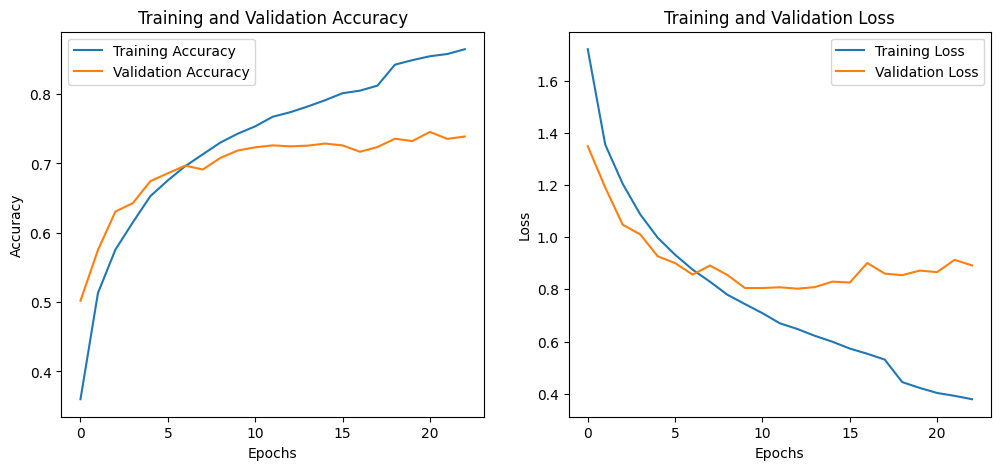

In [30]:
# Plot training & validation accuracy
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_simplecnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_simplecnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_simplecnn.history['loss'], label='Training Loss')
plt.plot(history_simplecnn.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### 4.3.4 Performence metrics

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Validation Classification Report for SimpleCNN:
               precision    recall  f1-score   support

    airplane       0.76      0.79      0.77       521
  automobile       0.78      0.89      0.83       514
        bird       0.64      0.59      0.61       475
         cat       0.54      0.53      0.54       500
        deer       0.67      0.69      0.68       494
         dog       0.66      0.60      0.63       522
        frog       0.72      0.84      0.78       489
       horse       0.79      0.72      0.75       472
        ship       0.85      0.79      0.82       511
       truck       0.82      0.79      0.81       502

    accuracy                           0.72      5000
   macro avg       0.72      0.72      0.72      5000
weighted avg       0.72      0.72      0.72      5000



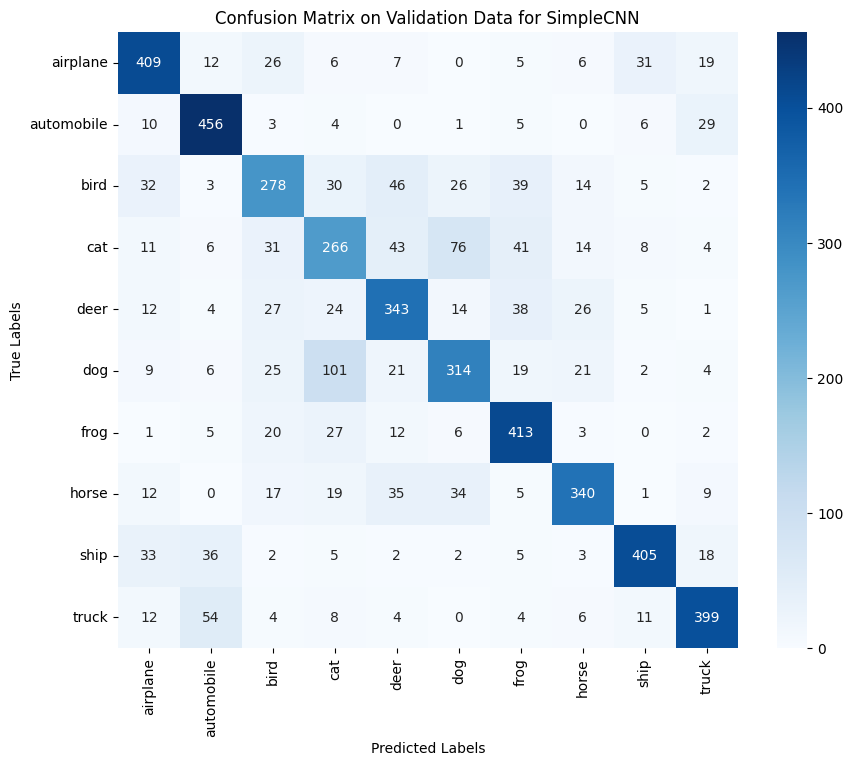

In [31]:
# Predict on the validation set
y_val_pred_simplecnn = SimpleCNN.predict(x_val)
y_val_pred_classes_simplecnn = y_val_pred_simplecnn.argmax(axis=1)

# Generate classification report for validation data
val_report_simplecnn = classification_report(y_val, y_val_pred_classes_simplecnn, target_names=class_names)
print("Validation Classification Report for SimpleCNN:\n", val_report_simplecnn)

# Generate confusion matrix for validation data
val_conf_matrix_simplecnn = confusion_matrix(y_val, y_val_pred_classes_simplecnn)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(val_conf_matrix_simplecnn, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix on Validation Data for SimpleCNN")
plt.show()

# 5. Hyper-parameter optimization

## 5.1 Best model identification

In [64]:
# Define a function to determine the best model and its validation accuracy
def get_best_model_and_score():
    # Dictionary to store the validation accuracies of the models
    models_accuracies = {
        "ResNet18": resnet18_validation_accuracy,
        "AlexNet": alexnet_validation_accuracy,
        "SimpleCNN": simplecnn_validation_accuracy
    }

    # Determine the model with the highest validation accuracy
    best_model = max(models_accuracies, key=models_accuracies.get)
    best_score = models_accuracies[best_model]

    return best_model, best_score

# Example usage to determine the best model and its score
best_model_name, best_model_score = get_best_model_and_score()
print(f"The best model based on validation accuracy is -")
print(f"Model: {best_model_name}")
print(f"Validation Accuracy: {best_model_score}")

The best model based on validation accuracy is -
Model: ResNet18
Validation Accuracy: 0.7897999882698059


## 5.2 Optimization for ResNet-18 on CIFAR-10

To achieve the best performance for ResNet-18 on CIFAR-10, we will focus on optimizing the following key hyperparameters:

1. **Learning Rate**: One of the most critical hyperparameters. We will experiment with a range, including [0.001, 0.0005], and consider using a learning rate decay strategy.
2. **Batch Size**: Common values are 64, and 128. A smaller batch size may help with generalization, while a larger batch size can speed up training.
3. **Optimizer**: While Adam is a popular choice, we will also try SGD with momentum (e.g., momentum value of 0.9) to see if it improves generalization.


In [68]:
# Define a refined hyperparameter grid without weight decay
learning_rates = [0.001, 0.0005]  # Narrowed down learning rates
batch_sizes = [64, 128]  # Reduced options for batch sizes
optimizers = ['SGD', 'Adam']  # Retaining both optimizers

# Initialize variables to store the best metrics and hyperparameters
best_val_accuracy = 0
lowest_val_loss = float('inf')
best_hyperparams = {}

# Iterate over the refined grid
for lr in learning_rates:
    for batch_size in batch_sizes:
        for optimizer_name in optimizers:
            # Create a new instance of the ResNet18 model
            model = build_resnet18(input_shape=(32, 32, 3), num_classes=10)

            # Choose the optimizer
            if optimizer_name == 'SGD':
                optimizer = SGD(learning_rate=lr, momentum=0.9)  # Removed weight decay
            else:
                optimizer = Adam(learning_rate=lr)  # Removed weight decay

            # Compile the model
            model.compile(
                optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy']
            )

            # Define callbacks: Early Stopping and Reduce Learning Rate on Plateau
            early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
            lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

            # Print the hyperparameters for the current iteration
            print(f"Training with: learning_rate={lr}, batch_size={batch_size}, optimizer={optimizer_name}")

            # Train the model with callbacks and display epoch number
            history = model.fit(
                x_train, y_train,
                validation_data=(x_val, y_val),
                epochs=15,
                batch_size=batch_size,
                callbacks=[early_stopping, lr_scheduler],
                verbose=1  # Show training progress, including epoch number
            )

            # Iterate over all completed epochs to find the best metrics
            for epoch in range(len(history.history['val_accuracy'])):
                val_accuracy = history.history['val_accuracy'][epoch]
                val_loss = history.history['val_loss'][epoch]

                # Check if this epoch has a better combination of high accuracy and low loss
                if val_accuracy > best_val_accuracy or (val_accuracy == best_val_accuracy and val_loss < lowest_val_loss):
                    best_val_accuracy = val_accuracy
                    lowest_val_loss = val_loss
                    best_hyperparams = {
                        "learning_rate": lr,
                        "batch_size": batch_size,
                        "optimizer": optimizer_name
                    }

# Print the best hyperparameters and their validation metrics
print(f"Best Hyperparameters: {best_hyperparams}")
print(f"Best Validation Accuracy: {best_val_accuracy}")
print(f"Lowest Validation Loss: {lowest_val_loss}")

Training with: learning_rate=0.001, batch_size=64, optimizer=SGD
Epoch 1/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 28s 21ms/step - accuracy: 0.3894 - loss: 1.6744 - val_accuracy: 0.5212 - val_loss: 1.3281 - learning_rate: 0.0010
Epoch 2/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.6169 - loss: 1.0728 - val_accuracy: 0.5610 - val_loss: 1.3059 - learning_rate: 0.0010
Epoch 3/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.7120 - loss: 0.8167 - val_accuracy: 0.6400 - val_loss: 1.0358 - learning_rate: 0.0010
Epoch 4/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.7998 - loss: 0.5908 - val_accuracy: 0.6594 - val_loss: 0.9879 - learning_rate: 0.0010
Epoch 5/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.8701 - loss: 0.3958 - val_accuracy: 0.6466 - val_loss: 1.1508 - learning_rate: 0.0010
Epoch 6/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.9257 - loss: 0.2437 - val_accuracy: 0.6176 - val_loss: 1.4096 - learning_rate: 0.0010
Epoch 7/15
782/7

## 5.3 Extract the best parameter and validation accuracy

In [69]:
# Print the best hyperparameters
print(f"Best Hyperparameters: {best_hyperparams}")

# Print the best validation accuracy
print(f"Best Validation Accuracy: {best_val_accuracy}")

# Print the lowest validation loss
print(f"Lowest Validation Loss: {lowest_val_loss}")

Best Hyperparameters: {'learning_rate': 0.0005, 'batch_size': 64, 'optimizer': 'Adam'}
Best Validation Accuracy: 0.8546000123023987
Lowest Validation Loss: 0.7046232223510742


# 6. Final Outcome

## 6.1 Training the model with best parameters

In [70]:
# Retrieve the best hyperparameters from the tuning process
best_lr = best_hyperparams['learning_rate']
best_batch_size = best_hyperparams['batch_size']
best_optimizer_name = best_hyperparams['optimizer']

# Print the best hyperparameters
print(f"Training with best hyperparameters: Learning Rate={best_lr}, Batch Size={best_batch_size}, Optimizer={best_optimizer_name}")

# Create a new instance of the ResNet18 model with the best parameters
model = build_resnet18(input_shape=(32, 32, 3), num_classes=10)

# Choose the optimizer based on the best choice
if best_optimizer_name == 'SGD':
    optimizer = SGD(learning_rate=best_lr, momentum=0.9)  # Removed weight decay
else:
    optimizer = Adam(learning_rate=best_lr)  # Removed weight decay

# Compile the model with the best hyperparameters
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model thoroughly with more epochs
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=50,  # Increase epochs for thorough training
    batch_size=best_batch_size,
    callbacks=[early_stopping],
    verbose=1
)

Training with best hyperparameters: Learning Rate=0.0005, Batch Size=64, Optimizer=Adam
Epoch 1/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 36s 24ms/step - accuracy: 0.4652 - loss: 1.5003 - val_accuracy: 0.6166 - val_loss: 1.1743
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.7391 - loss: 0.7523 - val_accuracy: 0.7438 - val_loss: 0.7505
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8157 - loss: 0.5230 - val_accuracy: 0.7826 - val_loss: 0.6473
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8630 - loss: 0.3906 - val_accuracy: 0.7710 - val_loss: 0.7111
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9051 - loss: 0.2761 - val_accuracy: 0.8040 - val_loss: 0.6176
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9291 - loss: 0.2018 - val_accuracy: 0.7562 - val_loss: 0.9326
Epoch 7/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9498 - loss: 0.1392 - val_accuracy: 0.7656 - val_loss: 0.9614
Ep

In [81]:
Accuracy = model.evaluate(x_val, y_val)[1]
Loss = model.evaluate(x_val, y_val)[0]

print(f"Validation Loss: {Loss}")
print(f"Validation Accuracy: {Accuracy}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8019 - loss: 0.6108
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8019 - loss: 0.6108
Validation Loss: 0.617654025554657
Validation Accuracy: 0.8040000200271606


In [83]:
# Save the trained model
model.save('best_resnet18_model.keras')  # Use the native Keras format for saving

print("Model saved successfully as 'best_resnet18_model.keras'")

Model saved successfully as 'best_resnet18_model.keras'


## 6.2 Accuray and Loss

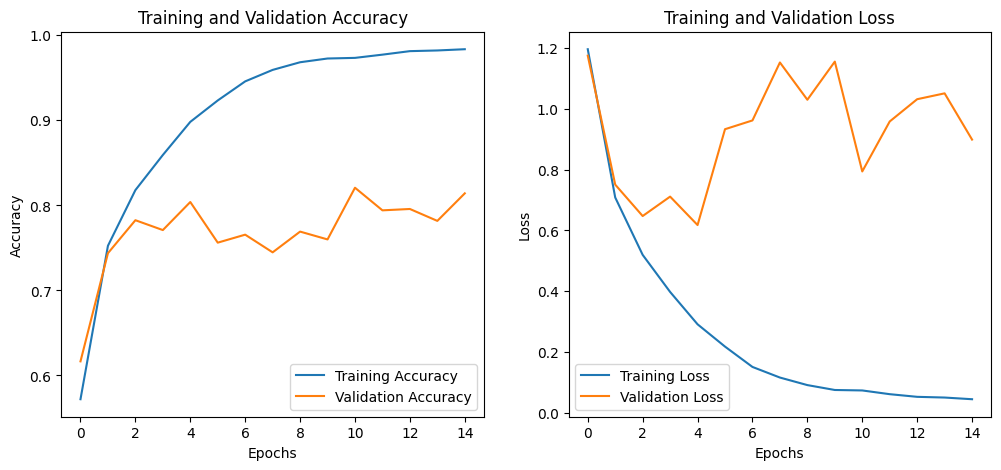

In [84]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## 6.3 Performance Metrics

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
Validation Classification Report:
               precision    recall  f1-score   support

    airplane       0.78      0.88      0.82       521
  automobile       0.87      0.93      0.90       514
        bird       0.68      0.75      0.71       475
         cat       0.69      0.69      0.69       500
        deer       0.73      0.85      0.79       494
         dog       0.85      0.61      0.71       522
        frog       0.87      0.79      0.83       489
       horse       0.77      0.87      0.81       472
        ship       0.95      0.80      0.87       511
       truck       0.91      0.86      0.89       502

    accuracy                           0.80      5000
   macro avg       0.81      0.80      0.80      5000
weighted avg       0.81      0.80      0.80      5000



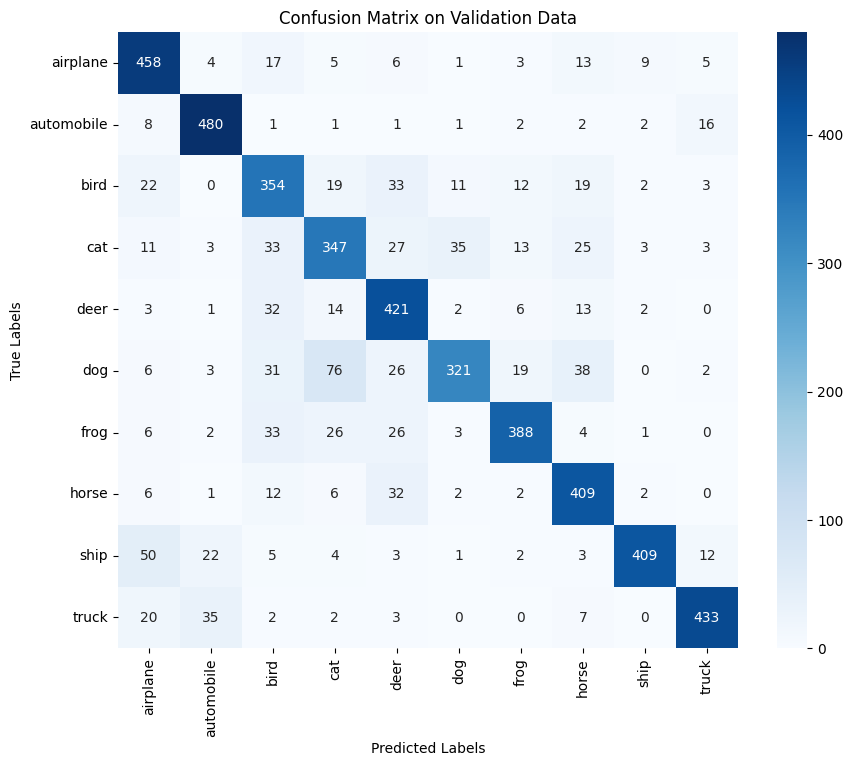

In [85]:
# Predict on the validation set
y_val_pred = model.predict(x_val)
y_val_pred_classes = y_val_pred.argmax(axis=1)

# Generate and print the classification report
val_report = classification_report(y_val, y_val_pred_classes, target_names=class_names)
print("Validation Classification Report:\n", val_report)

# Generate the confusion matrix
val_conf_matrix = confusion_matrix(y_val, y_val_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(val_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix on Validation Data")
plt.show()

## 6.4 Evaluating with test data

In [86]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7959 - loss: 0.6409
Test Loss: 0.6218176484107971
Test Accuracy: 0.8055999875068665


## 6.5 Performance Metrics

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Test Classification Report:
               precision    recall  f1-score   support

    airplane       0.76      0.87      0.82       479
  automobile       0.88      0.96      0.92       486
        bird       0.70      0.77      0.73       525
         cat       0.68      0.72      0.70       500
        deer       0.73      0.83      0.78       506
         dog       0.84      0.63      0.72       478
        frog       0.90      0.79      0.84       511
       horse       0.77      0.86      0.82       528
        ship       0.96      0.75      0.84       489
       truck       0.94      0.86      0.90       498

    accuracy                           0.81      5000
   macro avg       0.82      0.81      0.81      5000
weighted avg       0.81      0.81      0.81      5000



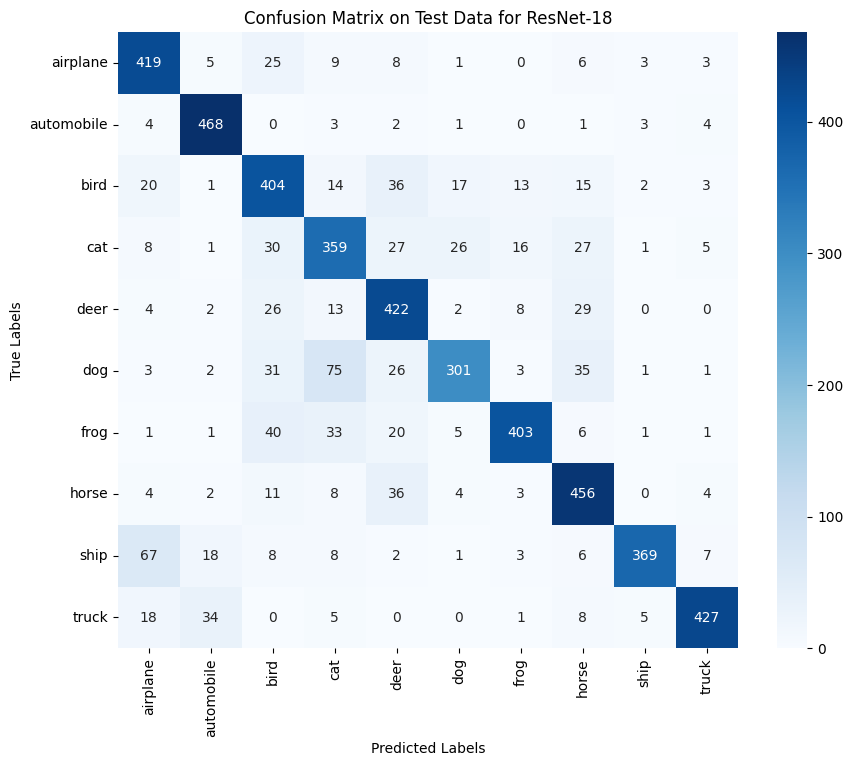

In [87]:
# Predict on the test set
y_test_pred = model.predict(x_test)
y_test_pred_classes = y_test_pred.argmax(axis=1)

# Generate classification report for the test data
test_report = classification_report(y_test, y_test_pred_classes, target_names=class_names)
print("Test Classification Report:\n", test_report)

# Generate confusion matrix for the test data
test_conf_matrix = confusion_matrix(y_test, y_test_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(test_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix on Test Data for ResNet-18")
plt.show()